In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import pywt
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
import os
from scipy import signal

# Robust Scaler for Meta Data

In [3]:
data_path = '/data/put_data/timliu/BG/'
d = pd.read_csv(data_path + 'new_IRB_summary_1457_1020.csv', dtype = 'str')
d = d.iloc[:, 2:]
for index, row in d.iterrows():
    if 'm' in row['ID']:
        d.iloc[index, 0] = d.iloc[index, 0] + '_m'
print(d[:5])
print(d.shape)

  Person No Age Gender Height  SYS DIA  HR    G  PWV   BMI BP_drug DM DM_drug  \
0       1_m  60      0  156.0   90  63  77  115  5.8  16.6       0  0       0   
1       1_m  60      0  156.0   88  60  74  114  6.4  16.6       0  0       0   
2       2_m  62      0  155.0  115  78  73  108  6.6  24.7       0  0       0   
3       2_m  62      0  155.0  115  79  74  111  6.5  24.7       0  0       0   
4       3_m  53      0  157.0  147  96  77  143  7.3  25.4       0  0       0   

  O_drug W_cir weight       ID      Date  Time  
0      0  61.5   40.5  001_1_m  20170302  1124  
1      0  61.5   40.5  001_2_m  20170302  1130  
2      0  80.0   59.4  002_1_m  20170302  1150  
3      0  80.0   59.4  002_2_m  20170302  1154  
4      1  83.0   62.7  003_1_m  20170302  1203  
(2914, 19)


In [4]:
data_path = '/data/put_data/timliu/BG/'
d = pd.read_csv(data_path + 'new_IRB_summary_338_1020.csv')
d[:5]

,Unnamed: 0,Person No,Age,Gender,Height,SYS,DIA,HR,G,PWV,BMI,BP_drug,DM,DM_drug,O_drug,W_cir,weight,ID,Date,Time
0,1,1,60,0,156.0,90,63,77,115,5.8,16.6,0,0,0,0,61.5,40.5,001_1,20170302,1124
1,2,1,60,0,156.0,88,60,74,114,6.4,16.6,0,0,0,0,61.5,40.5,001_2,20170302,1130
2,3,2,62,0,155.0,115,78,73,108,6.6,24.7,0,0,0,0,80.0,59.4,002_1,20170302,1150
3,4,2,62,0,155.0,115,79,74,111,6.5,24.7,0,0,0,0,80.0,59.4,002_2,20170302,1154
4,5,3,53,0,157.0,147,96,77,143,7.3,25.4,0,0,0,1,83.0,62.7,003_1,20170302,1203


In [197]:
os.chdir('/data/put_data/timliu/BG/')
d3 = d.append(d2)
d3.to_csv('new_IRB_summary_1457_1020.csv')

In [43]:
os.chdir('/data/put_data/timliu/BG/pro_data_ACDC_1020/')
for filename in os.listdir('.'):
    if int(filename.split('_')[0]) <= 250:
        os.rename(filename, filename.split('.')[0] + '_m.csv')

In [192]:
for index, row in d.iterrows():
    if int(row['Person No']) <= 250:
        d.iloc[index, 17] = row['ID'] + '_m'

In [56]:
f = os.path.join('/data/put_data/timliu/BG/pro_data_AC_1020/' + d['ID'] + '.csv')
X = {}
for i in range(d.shape[0]):
    di = np.genfromtxt(f[i],delimiter=',',skip_header=True)
    di = di[:, 1:]
    X[d.iloc[i]['ID']] = di

In [57]:
# read raw ECG/PPG AC/DC component
f2 = os.path.join('/data/put_data/timliu/BG/pro_data_ACDC_1020/' + d['ID'] + '.csv')
X2 = {}
for i in range(d.shape[0]):
    di = np.genfromtxt(f2[i],delimiter=',',skip_header=True)
    di = di[:, 1:]
    X2[d.iloc[i]['ID']] = di
    
# combine both 5 channels to 10 channels
all_X = {}
for key, value in enumerate(X):
    all_X[value] = np.hstack((X[value][2000:-3000, :], X2[value][2000:-3000, :]))

# dumping all raw signal
with open('/data/put_data/timliu/BG/1006_data/dict_X_C10_all_1020.pickle', 'wb') as h:
    pickle.dump(all_X, h)

In [162]:
dd = np.concatenate((df, np.array(d[['Gender', 'BP_drug', 'DM', 'DM_drug', 'O_drug']])), axis = 1)

In [203]:
meta = {}
i = 0
for index, row in d.iterrows():
    meta[row['ID']] = np.array(dd[i, :], dtype = 'float32')
    i += 1

In [205]:
with open('/data/put_data/timliu/BG/1006_data/dict_meta_1020.pickle', 'wb') as handle:
    pickle.dump(meta, handle)

In [200]:
robust_scaler = RobustScaler()
d = d3
df = d.drop(['Unnamed: 0', 'Person No', 'Gender', 'BP_drug','DM','DM_drug','O_drug','ID','Date','Time','G'], axis = 1)
# df = d.drop(['HbA1C','HDL','LDL','TC','TG','Person No', 'ID', 'Gender', 'BP_drug', 'G', 'DM', 'DM_drug', 'O_drug', 'Date', 'Time'], axis = 1)
# df = d.drop(['Person No', 'ID', 'Gender', 'BP_drug', 'G', 'DM', 'DM_drug', 'O_drug', 'Date', 'Time'], axis = 1)
# df = df.iloc[:, :13]
df = np.asarray(df, dtype=np.float)

df = robust_scaler.fit_transform(df)
df_norm = pd.concat([pd.DataFrame(df), pd.DataFrame(d, columns = ['Gender', 'BP_drug', 'DM', 'DM_drug', 'O_drug'])], axis = 1)

meta = {}
for i in range(d.shape[0]):
    meta[d.iloc[i]['ID']] = np.array(df_norm.iloc[i], dtype = 'float32')
# with open('/data/put_data/timliu/BG/1006_data/dict_meta_1020.pickle', 'wb') as handle:
#     pickle.dump(meta, handle)

ValueError: Shape of passed values is (14, 3590), indices imply (14, 2914)

# Grid Plot for Abnormal Signal Detecting

In [46]:
with open('/data/put_data/timliu/BG/1006_data/dict_X_C10_1020_final.pickle', 'rb') as h:
    X = pickle.load(h)

In [22]:
# AC AC/DC only
directory = '/data/put_data/timliu/BG/signal/AC/'
if not os.path.exists(directory):
    os.makedirs(directory)
started = 0 
channel = 0  # if AC/DC = 5
all_d = d['Person No'].unique()
for i in range(len(all_d)):
    number = all_d[i]
    id_df = d.loc[d['Person No'] == number]
    id_ = np.array(id_df['ID'])
    if id_.shape[0] == 2:
        f, axarr = plt.subplots(5,2,sharex='col', sharey='row',figsize=(20, 40))
        f.suptitle('AC/DC', fontsize=60)
        # ex 003_1
        id_1 = id_[0]
        axarr[started, 0].plot(X[id_1][:,channel],color = 'g')
        axarr[started, 0].set_ylabel('ECG', fontsize=20)
        axarr[started, 0].set_title(id_1,fontsize=20)
        axarr[started+1, 0].plot(X[id_1][:,channel+1])
        axarr[started+1, 0].set_ylabel('LR', fontsize=20)
        axarr[started+2, 0].plot(X[id_1][:,channel+2])
        axarr[started+2, 0].set_ylabel('LIR', fontsize = 20)
        axarr[started+3, 0].plot(X[id_1][:,channel+3])
        axarr[started+3, 0].set_ylabel('RR', fontsize = 20)
        axarr[started+4, 0].plot(X[id_1][:,channel+4])
        axarr[started+4, 0].set_ylabel('RIR', fontsize = 20)
        # ex 003_2
        id_2 = id_[1]
        axarr[started, 1].plot(X[id_2][:,channel],color = 'g')
        axarr[started, 1].set_title(id_2,fontsize=20)
        axarr[started+1, 1].plot(X[id_2][:,channel+1])
        axarr[started+2, 1].plot(X[id_2][:,channel+2])
        axarr[started+3, 1].plot(X[id_2][:,channel+3])
        axarr[started+4, 1].plot(X[id_2][:,channel+4])
        f.subplots_adjust(hspace=0.1, wspace = 0.1)
        f.savefig(directory + str(number) + ".png")
        plt.close()
    else:
        f, axarr = plt.subplots(5,1,sharex='col', sharey='row',figsize=(20, 40))
        f.suptitle('AC/DC', fontsize=60)
        id_1 = id_[0]
        axarr[started].plot(X[id_1][:,channel],color = 'g')
        axarr[started].set_ylabel('ECG', fontsize=20)
        axarr[started].set_title(id_1,fontsize=20)
        axarr[started+1].plot(X[id_1][:,channel+1])
        axarr[started+1].set_ylabel('LR', fontsize=20)
        axarr[started+2].plot(X[id_1][:,channel+2])
        axarr[started+2].set_ylabel('LIR', fontsize = 20)
        axarr[started+3].plot(X[id_1][:,channel+3])
        axarr[started+3].set_ylabel('RR', fontsize = 20)
        axarr[started+4].plot(X[id_1][:,channel+4])
        axarr[started+4].set_ylabel('RIR', fontsize = 20)
        f.subplots_adjust(hspace=0.1, wspace = 0.1)
        f.savefig(directory + str(number) + ".png")
        plt.close()
    print('\rProcess data: {}%'.format(round((i+1)/len(all_d)*100, 2)), end='',flush=True)

Process data: 100.0%

# Raw Signal Combination and Trim

In [30]:
# read raw ECG/PPG AC component
f = os.path.join('/data/put_data/timliu/BG/pro_data_AC/' + d['ID'] + '.csv')
X = {}
for i in range(d.shape[0]):
    di = np.genfromtxt(f[i],delimiter=',',skip_header=True)
    di = di[:, 1:]
    X[d.iloc[i]['ID']] = di
    
# read raw ECG/PPG AC/DC component
f2 = os.path.join('/data/put_data/timliu/BG/pro_data_ACDC/' + d['ID'] + '.csv')
X2 = {}
for i in range(d.shape[0]):
    di = np.genfromtxt(f2[i],delimiter=',',skip_header=True)
    di = di[:, 1:]
    X2[d.iloc[i]['ID']] = di
    
# combine both 5 channels to 10 channels
all_X = {}
for key, value in enumerate(X):
    all_X[value] = np.hstack((X[value][2000:-3000, :], X2[value][2000:-3000, :]))

# dumping all raw signal
with open('/data/put_data/timliu/BG/1006_data/dict_X_C10_all.pickle', 'wb') as h:
    pickle.dump(all_X, h)

# Robust scaler & downsampling for ECG/PPG

In [162]:
with open('/data/put_data/timliu/BG/1006_data/dict_X_C10_1020_final.pickle', 'rb') as h:
    all_X2 = pickle.load(h)

In [65]:
c = dict(all_X, **all_X2)

In [4]:
import random, pickle
'''open raw signal'''
with open('/data/put_data/timliu/BG/1006_data/dict_X_C10_1020_final_5sec.pickle', 'rb') as h:
    all_X = pickle.load(h)

In [187]:
x = all_X['003_1'][:, 6]
x.shape

(40740,)

In [188]:
x = (x - np.mean(x))/np.std(x)

In [115]:
from scipy import signal
b, a = signal.butter(8, 0.1)
y = signal.filtfilt(b, a, x)

In [127]:
b, a = signal.butter(8, 0.002)
y2 = signal.filtfilt(b, a, x)

In [131]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low,high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

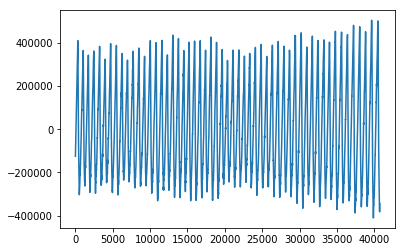

In [146]:
plt.plot(all_X['003_1'][:, 1])
plt.show()
plt.close()

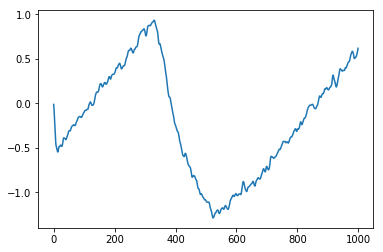

In [191]:
plt.plot(butter_bandpass_filter(x, 0.05, 50, 1000, order=2))
plt.show()
plt.close()

In [217]:
with open('/data/put_data/timliu/BG/1107_data/dict_X_C4_lfilter_1107.pickle', 'wb') as h:
    pickle.dump(all_X_2, h)

In [198]:
'''stack all data for robust scaler'''
all_data = [all_X[val][:,6:] for key, val in enumerate(all_X)]
all_data = np.vstack(all_data)
# from sklearn.preprocessing import RobustScaler
# robust_scaler = RobustScaler()
# t = robust_scaler.fit_transform(all_data)
all_mean = np.mean(all_data)
all_std = np.std(all_data)

# '''downsample to 200Hz'''
n_sample = 2500
import scipy.signal
all_X_2 = {}
for index, key in enumerate(all_X):
#     x = robust_scaler.transform(all_X[key][:, :])
    x = (all_X[key][:, 6:] - all_mean)/all_std
    butter_bandpass_filter(x, 0.05, 50, 1000, order=4)
    x = scipy.signal.decimate(x, 2, axis = 0)
    sample_x = {}
    j = 0
    for i in range(8):
#         j = random.randint(0,int(x.shape[0]-n_sample))
        j = int(j + (i*0.5)*n_sample)
        sample_x[i] = x[j:(j+n_sample), :]
        if x[j:(j+n_sample), :].shape[0] < 2500:
            j = random.randint(0,int(x.shape[0]-n_sample))
            sample_x[i] = x[j:(j+n_sample), :]
    all_X_2[key] = sample_x

# with open('/data/put_data/timliu/BG/1103_data/dict_X_C10_tkeo_1103.pickle', 'wb') as h:
#     pickle.dump(all_X_2, h)
    
# '''random select 5 30s siganl from original'''
# n_sample = 30000
# import scipy.signal
# all_X_2 = {}
# for key,val in enumerate(all_X):
#     x = robust_scaler.transform(all_X[val])
#     sample_x = {}
#     for i in range(5):
#         j = random.randint(0,int(x.shape[0]-n_sample))
#         sample_x[i] = x[j:(j+n_sample), :]
#     all_X_2[val] = sample_x

# '''down sample for each short signal'''
# downsample = [5,20,40,10]
# for d in downsample:
#     down_X = {}
#     for key, val in all_X_2.items():
#         dict_x = all_X_2[key]
#         dict_X = {}
#         for key2, val2 in dict_x.items():
#             x = scipy.signal.decimate(dict_x[key2], d, axis = 0)
#             dict_X[key2] = x
#         down_X[key] = dict_X
#     with open('/data/put_data/timliu/BG/1006_data/' + 'dict_X_C10_S5_%s'%(str(int(1000/d))) + '_5sec.pickle', 'wb') as h:
#         pickle.dump(down_X, h)

/usr/local/lib/python3.5/dist-packages/scipy/signal/signaltools.py:3402: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


# Moving Average of Signal

In [4]:
'''open raw signal'''
file_path = '/data/put_data/timliu/BG/'
with open(file_path+'train_test/data/dict_X_C10_all_newtrim_0831.pickle', 'rb') as h:
    all_X = pickle.load(h)

In [29]:
t = all_X['004_2'][:,0]

In [30]:
df = pd.DataFrame(t)

In [89]:
df_mean = df.rolling(window=10).mean()

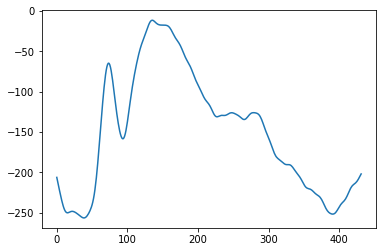

In [115]:
plt.plot(t[27280:27712])
plt.show()
plt.close()

In [90]:
df_mean[19600:19640]

,0
19600,32.298833
19601,32.684443
19602,33.126959
19603,33.603166
19604,34.086798
19605,34.553112
19606,34.982625
19607,35.363279
19608,35.690594
19609,35.965805


In [110]:
df_mean = np.array(df_mean)
error = []
for i in range(df_mean.shape[0]):
    try:
        if i % 10 ==0:
            diff = abs(df_mean[i] - df_mean[i+10])/df_mean[i]
            if diff >= 80:
                error.append(i)
    except:
        pass

In [111]:
error

[7660, 8940, 11810, 12530, 22390, 35720, 36060, 37430]